In [71]:
%matplotlib inline

In [72]:
import matplotlib.pyplot as plt
import numpy as np
import time
import math
from collections import Counter
from tqdm import tqdm

from tiles import *

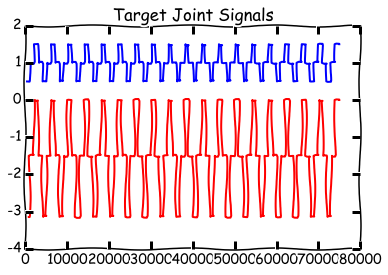

In [73]:
plt.xkcd()  # Yes...

tmax = 75000

phase1maxT = 100000
phase2maxT = phase1maxT + 100000

t = tmax*np.linspace(0, 1, tmax, endpoint=False)

# Define the target angles
targetAngles = np.zeros((tmax,2))
for i in range(0, tmax, 4000): 
    targetAngles[i:i+1000,0] = 0.5
    targetAngles[i+1000:i+2000,0] = 1
    targetAngles[i+2000:i+3000,0] = 1.5
    targetAngles[i+3000:i+4000,0] = 1
    targetAngles[i:i+1000,1] = -np.pi
    targetAngles[i+1000:i+2000,1] = -1.5
    targetAngles[i+2000:i+3000,1] = 0
    targetAngles[i+3000:i+4000,1] = -1.5
    
angleMins = np.amin(targetAngles,0)
angleMaxs = np.amax(targetAngles,0)

# Two subplots, unpack the axes array immediately
plt.figure(figsize=(40,40))
f, ax1 = plt.subplots(1, 1, sharey=False)

ax1.plot(t, targetAngles)
ax1.set_title('Target Joint Signals')

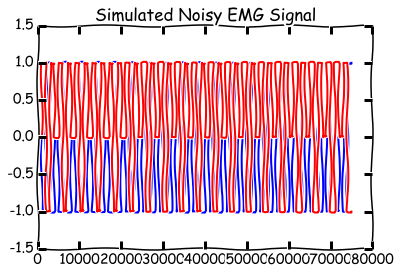

In [ ]:
delay = 0

# Noise is defined by a random normal variable 
noise = np.random.normal(0,0.001,(tmax,2))
simEMG = np.zeros((tmax+delay,2))

for i in range(1,tmax):
    if targetAngles[i,0] == 1:
        simEMG[i + delay,0] = -1
        simEMG[i + delay,1] = 1
    elif targetAngles[i,0] < 1:
        simEMG[i + delay,0] = 0
        simEMG[i + delay,1] = 0        
    elif targetAngles[i,0] > 1:
        simEMG[i + delay,0] = 1
        simEMG[i + delay,1] = -1
        
simEMGdiff = simEMG[0:tmax] # + noise

emgMins = np.amin(simEMGdiff,0)
emgMaxs = np.amax(simEMGdiff,0)

plt.figure(figsize=(40,40))
f, ax2 = plt.subplots(1, 1, sharey=False)
ax2.plot(t, simEMGdiff)
ax2.set_ylim(-1.5, 1.5)
ax2.set_title('Simulated Noisy EMG Signal')

In [ ]:
# Implement a learning algorithm to try to fit the signal
numJoints = 1
numEMG = 2

jointAngle = np.zeros((tmax,numJoints))

# Initialize the state array for the trajectory
# Possible feedback from the simulated arm includes the angle
# (in radians) and angular velocity (in radians per second) of
# each joint, and the Cartesian position of the end effector.

# Initialize the continuous state space 
# composed of joint angles (thetaW,thetaE)
# and differential EMG signals (dS1,dS2)
# thetaW, thetaE, dS1, dS2
s = np.zeros(numJoints+numEMG)

# Standard deviation should cover the possible action set
maxAngVelInt_stdC = 1023

# Initialize the saved variables
reward = np.zeros(tmax)
delta = np.zeros(tmax)

agentMean = np.zeros((tmax,numJoints))
agentStd = np.zeros((tmax,numJoints))

# define the number of tilings
numTilings = 5 # 5 25

# this defines the resolution of the tiling
resolutions = np.array([3,5,8,12,20]) # resolutions = np.array([5,8,12,20])

numFeatures = len(s)

# Initialize the learning parameters
# m is the number of active features in the feature vector
m = numTilings * len(resolutions) + 1

gamma = 0.95 # 0.97
lambd = 0.3

# Different values for the 2013 paper
lambdw = 0.3
lambdv = lambdw # 0.7

alphaV = 0.1/m
alphaW = 0.01/m

alphaU = alphaW # 0.005/m # 0.01/m
alphaS = alphaW # 0.25*alphaU # 0.01/m #

# Actual length is the concatenation at different resolutions
# and the baseline feature
featVecLength = sum(np.power(resolutions,numFeatures)*numTilings)+1

# Initialize the weight vectors to zero 
# the should be as long as the feature vector x
elV = np.zeros(featVecLength)
v = np.zeros(featVecLength)

elU = np.zeros((featVecLength,numJoints))
elS = np.zeros((featVecLength,numJoints))
wU = np.zeros((featVecLength,numJoints))
wS = np.zeros((featVecLength,numJoints))

# This function converts the angular velocity from an integer in the range [-1023,1023]
# to an angular velocity in radians per second.
# The no-load speed of the motor is ~60RPM, which is around 6 radians per second
# rad/s = rot(RPM) 2*pi/60
# This should give a good simulation of the true robotic kinematics
def conAngIntToangVel(angInt):
    motorVel = 60
    angVel = motorVel * angInt / maxAngVelInt_stdC
    return angVel

def normalize(val,oldmin,oldmax,newmin,newmax):
    # All components in s were normalized to the range [0, 1]
    # according to their minimum and maximum POSSIBLE VALUES!
    return (((val - oldmin) * (newmax - newmin)) / (oldmax - oldmin)) + newmin

def featurize(s):
    
    normS = np.zeros(len(s))
    
    for j in np.arange(numJoints):
        normS[j] = normalize(s[j],-4,2,0,1)
    
    for i in np.arange(numJoints,numJoints+numEMG):
        normS[i] = normalize(s[i],-1.5,1.5,0,1)
    
    # x is the active tiles in this featurization
    # This featurization should return a single binary feature vector
    # with exactly m features in x(s) active at any time
    # Binary feature vector has a length of 4636426 or
    # sum(np.power(np.array([5,8,12,20]),4)*25)+1
    x = np.zeros(1)
    
    # Single active baseline unit
    x[0] = 1 
    
    # For each resolution the features are needed 
    for res in np.nditer(resolutions):
        
        resVec = np.zeros(np.power(res,numFeatures)*numTilings)
        
        floatArray = []
        
        for j in range(len(normS)):
            floatArray.append(normS[j]*res)
 
        # Get the indexes of the tiles
        tilesOut = tiles(numTilings, res, floatArray) 
        
        # For each tile index flip a feature in the feature vector
        for tileIndex in range(len(tilesOut)):
            resVec[tilesOut[tileIndex] + (res**2 * tileIndex)] = 1
        
        x = np.append(x,resVec)
    return x

def getReward(newAngles,timeStep):
    # Define the reward function of the system
    # A positive reward of rt = 1.0 was
    # delivered when θw and θe were both within 0.1 radians of
    # their target angles. A reward of rt = −0.5 was delivered
    # in all other cases, in essence penalizing the learning system
    # when the arm’s posture differed from the target posture.

    target = targetAngles[timeStep,range(numJoints)]    
    absAngleError = np.abs(newAngles-target)
    
    if all(absAngleError < 0.1):
        r = 0.1
    else:
        r = -0.5

    return r

def perform(vel,s,timeStep):
    
    # take the action and observe the new state and the reward 
    # new state is defined by the new joint angle
    # which is defined by the old joint angle and the new angular velocity
    # which is applied for that time step and the
    # emg signal at that time index 
    
    # Calculate the new angular state of the joint
    # old angle + angular velocity * time (in this case time = 5ms, the period of action selection)
    # this limits the amount of motion of the joint possible in each action selection

    # Define the new state space with the new angle and the emg information from the next step    
    newAngles = np.zeros(numJoints)
    newAngles[:] = np.clip((s[:numJoints] + (vel[:] * 0.005)), 0, math.pi)
  
    s = np.hstack((newAngles,simEMGdiff[timeStep,range(numEMG)]))
    
    # Get the reward for the new angle
    r = getReward(newAngles,timeStep)
    
    return r,s

# process the training samples that are given
for i in tqdm(range(tmax)):
    
    jointAngle[i,:] = s[:numJoints]
   
    # Featurize the state
    x = featurize(s)
    
    a = np.zeros(numJoints)
    angVels = np.zeros(numJoints)
    
    # Calculate the mean and standard deviation of the action selection
    for j in range(numJoints):      
        agentMean[i,j] = np.dot(wU[:,j],x)
        agentStd[i,j] = max(1,np.exp(np.dot(wS[:,j],x) + np.log(maxAngVelInt_stdC)))

        # get the action from the normal distribution
        # angular velocity commands are sent to joints (simulated servos) 
        # as integers in the range [−maxAngVelInt_stdC, maxAngVelInt_stdC] 
        a[j] = round(np.random.normal(agentMean[i,j],agentStd[i,j])) 
    
        # If the action is outside the range, crop to the range
        if a[j] < -maxAngVelInt_stdC:
            a[j] = -maxAngVelInt_stdC
        elif a[j] > maxAngVelInt_stdC:
            a[j] = maxAngVelInt_stdC
        
        # Convert the action to an angular velocity
        angVels[j] = conAngIntToangVel(a[j])

    # Take action a and observe the reward, r, and the new state, s
    reward[i],s = perform(angVels,s,i)

    if numJoints > 1:
        # Initially, parameter vectors for the wrist and elbow joints
        # were each trained in isolation for 100k time steps;
        if i < phase1maxT:
            # set joint 2 to desired position
            s[1] = targetAngles[i,1]

        elif i < phase2maxT:
            # set joint 1 to desired position
            s[0] = targetAngles[i,0]

    # Featurize the new state
    newX = featurize(s)

    # Calculate the TD Error based on the old state and the new state
    delta[i] = reward[i] + (gamma * np.dot(v,newX)) - np.dot(v,x)
    
    # Critic's eligibility traces 
    # Updated eligibility trace from the 2013 paper
    # replacing eligibility traces in the critic used to accelerate learning
    elV = (lambdv * elV) + x
    elV = np.minimum(np.ones(featVecLength),elV)

    # Critic's parameter vector
    v = v + (alphaV * delta[i] * elV)

    if numJoints > 1:
    # Initially, parameter vectors for the wrist and elbow joints
    # were each trained in isolation for 100k time steps;
        if i < phase1maxT:
            # learn parameter vectors for joint 1
            # set joint 2 to desired position
            s[1] = targetAngles[i,1]
            elU[:,0] = lambdw * elU[:,0] + np.multiply((a[0] - agentMean[i,0]),x)
            wU[:,0] = wU[:,0] + alphaU * delta[i] * elU[:,0]
            elS[:,0] = lambdw * elS[:,0] + np.multiply(((np.power((a[0] - agentMean[i,0]),2) / np.power(agentStd[i,0],2)) - 1),x)
            wS[:,0] = wS[:,0] + alphaS * delta[i] * elS[:,0]

        elif i < phase2maxT:
            # learn parameter vectors for joint 2
            # set joint 1 to desired position
            s[0] = targetAngles[i,0]
            elU[:,1] = lambdw * elU[:,1] + np.multiply((a[1] - agentMean[i,1]),x)
            wU[:,1] = wU[:,1] + alphaU * delta[i] * elU[:,1]
            elS[:,1] = lambdw * elS[:,1] + np.multiply(((np.power((a[1] - agentMean[i,1]),2) / np.power(agentStd[i,1],2)) - 1),x)
            wS[:,1] = wS[:,1] + alphaS * delta[i] * elS[:,1]
        
        else:  
            for j in range(numJoints):
                # Actors parameters (eligibiliy traces and weight vectors)
                elU[:,j] = lambdw * elU[:,j] + np.multiply((a[j] - agentMean[i,j]),x)
                wU[:,j] = wU[:,j] + alphaU * delta[i] * elU[:,j]
                elS[:,j] = lambdw * elS[:,j] + np.multiply(((np.power((a[j] - agentMean[i,j]),2) / np.power(agentStd[i,j],2)) - 1),x)
                wS[:,j] = wS[:,j] + alphaS * delta[i] * elS[:,j]
    else:  
        for j in range(numJoints):
            # Actors parameters (eligibiliy traces and weight vectors)
            elU[:,j] = lambdw * elU[:,j] + np.multiply((a[j] - agentMean[i,j]),x)
            wU[:,j] = wU[:,j] + alphaU * delta[i] * elU[:,j]
            elS[:,j] = lambdw * elS[:,j] + np.multiply(((np.power((a[j] - agentMean[i,j]),2) / np.power(agentStd[i,j],2)) - 1),x)
            wS[:,j] = wS[:,j] + alphaS * delta[i] * elS[:,j]
        
    if (i%50000 == 0):
        print 'Step: ' + str(i)
        print np.sum(reward)
#     print 'Joint Angle: ' + str(jointAngle[i,:]) + ' rads'
#     print 'Target Angle: ' + str(targetAngles[i,range(numJoints)]) + ' rads'
#     print 'Agent Mean: ' + str(agentMean[i,:])
#     print 'Agent Std: ' + str(agentStd[i,:])
#     print 'Action: ' + str(angVels) + ' rad/s, move ' + str(angVels*0.005) + ' rads'
#     print 'New Joint Angles: ' + str(s[range(numJoints)]) + ' rads'
#     print 'Reward: ' + str(reward[i])
#     print 'TD Error: ' + str(delta[i])
#     print '\n'

|#####-----| 44173/75000  58% [elapsed: 01:23 left: 00:58, 531.16 iters/sec]

In [ ]:
# Visualize the learning    
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(t, targetAngles[:,range(numJoints)])
ax1.set_title('Target Angles')

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(t, jointAngle)
ax1.set_title('Learned Joint Angles')

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(t, delta)
ax1.set_title('TD Error')

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(t, np.cumsum(reward))
ax1.set_title('Cumulative Return')

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(t, agentMean)
ax1.set_title('Agent Mean')

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(t, agentStd)
ax1.set_title('Agent Standard Deviation')

##### 

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(t[-30000:], jointAngle[-30000:])
ax1.plot(t[-30000:], targetAngles[-30000:])
ax1.set_title('Target and Learned Angles')
ax1.set_ylim([0, 2])

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(t[0:30000], agentMean[0:30000])
ax1.set_title('Agent Mean')

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(t[0:30000], agentStd[0:30000])
ax1.set_title('Agent Standard Deviation')

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(t[-30000:], agentMean[-30000:])
ax1.set_title('Agent Mean')

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(t[-30000:], agentStd[-30000:])
ax1.set_title('Agent Standard Deviation')